# Evaluate land model output from perturbed parameter ensemble

This script evaluates model output from a set of ensemble members in a perturbed parameter experiment. It identifies the best-performing ensemble members

## Import modules

In [2]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools
import netCDF4 as nc4
import importlib
import esm_tools
importlib.reload(esm_tools)

<module 'esm_tools' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_tools.py'>

## Define paths and script parameters

In [3]:
# Benchmarking metrics
my_metrics = ["BA","AGB","TreeStemD","ShannonE","NPP","FailedPFTs"]

# Optional
case_path = None

# Path where case output lives
case_output_root = '/glade/scratch/adamhb/archive'

# Path to ensemble params
params_root = '/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles'

# Path to put any processed output
processed_output_root = '/glade/scratch/adamhb/processed_output'

# Path to param range files
param_range_root = '/glade/u/home/adamhb/california-fates/parameter_ranges/param_range_archive'

## Variables to import

In [4]:
# Keep first two no matter what. They are needed to unravel multi-plexed dimensions
fields = ['FATES_SEED_PROD_USTORY_SZ','FATES_VEGC_AP','FATES_BURNFRAC',
          'FATES_NPLANT_PF','FATES_NPLANT_SZPF','FATES_FIRE_INTENSITY_BURNFRAC','FATES_IGNITIONS',
          'FATES_MORTALITY_FIRE_SZPF','FATES_BASALAREA_SZPF','FATES_CANOPYCROWNAREA_APPF',
          'FATES_CROWNAREA_APPF','FATES_FUEL_AMOUNT_APFC','FATES_NPLANT_SZPF',
          'FATES_PATCHAREA_AP','FATES_CROWNAREA_PF','FATES_VEGC_ABOVEGROUND','FATES_NPP_PF']

## Benchmarking functions

In [25]:
def setup_benchmarking_data_structure(metrics,parameters,pft_names):
    
    metrics_out = metrics.copy()
    
    # add pft-specific vars
    pft_specific_ba_metrics = ["BA_" + pft for pft in pft_names]  
    metrics_out.extend(pft_specific_ba_metrics)
    
    # add inst tag
    metrics_out.append("inst")    
    metrics_out.extend(parameters)
    
    benchmarking_dict = {}
    for i in metrics_out:
        benchmarking_dict[i] = []
    return benchmarking_dict

def get_benchmarks(case_name,metrics,last_n_years,param_sub_dir,param_range_file_name,
                   test = False, pft_names = np.array(["pine","cedar","fir","shrub","oak"]),
                   pft_colors = ['gold','darkorange','darkolivegreen','brown','springgreen'],
                   param_range_root = param_range_root,
                   params_root = params_root):
      
    print("Case:",case_name)
    
    # 1. Get info about the case
    full_case_path = esm_tools.get_path_to_sim(case_name,case_output_root)
    inst_tags = esm_tools.get_unique_inst_tags(full_case_path)
    
    if test == True:
        inst_tags = inst_tags[:3]
    
    n_inst = len(inst_tags)
    print("ninst:",n_inst)
    
    # 2. Set up the benchmarking data structure
    perturbed_params_df = pd.read_csv(os.path.join(param_range_root,param_range_file_name))
    perturbed_params = []
    for i in range(len(perturbed_params_df)):
        perturbed_params.append(perturbed_params_df['param'][i] + "_" + str(perturbed_params_df['pft'][i]))
    
    bench_dict = setup_benchmarking_data_structure(metrics,perturbed_params,pft_names)  
                                 
    # 3. Add param values to the data structure
    for inst in inst_tags:
        param_file_path = esm_tools.get_parameter_file_of_inst(params_root,param_sub_dir,inst)
        
        i = 0                      
        for param,pf in zip(perturbed_params_df['param'], perturbed_params_df['pft']):
            i = i + 1
            bench_dict[perturbed_params[i-1]].append(esm_tools.extract_variable_from_netcdf(
                                                           param_file_path,param,pf))
    
    # 4. Add the model output to the data structure
    for inst in inst_tags:
        
        print("Working on ensemble memeber",inst,"of",len(inst_tags),"members")
        
        # Import the model output data for one ensemble member
        inst_files = esm_tools.get_files_of_inst(full_case_path,
                                                 inst,
                                                 last_n_years)
        
        ds = esm_tools.multiple_netcdf_to_xarray(inst_files,fields)
        
        bench_dict['inst'].append(inst)
        
        ## Basal area [m2 ha-1] ##
        if "BA" in bench_dict.keys():
            
            ## Pft-specific BA
            pft_level_ba = esm_tools.get_pft_level_basal_area(ds)
            
            for i in range(len(pft_names)):
                pft_name = pft_names[i]
                bench_dict['BA_' + pft_name].append(pft_level_ba[i])
            
            ## Shannon equitability index (wrt BA) ##
            bench_dict['ShannonE'].append(esm_tools.shannon_equitability(pft_level_ba))
            
            ## Number of failed pfts ##
            bench_dict['FailedPFTs'].append(esm_tools.get_n_failed_pfts(pft_level_ba,ba_thresh=0.1))
            
            ## Total BA
            bench_dict['BA'].append(pft_level_ba.sum())
                  
        ## Stem density [N ha-1] ##
        if "TreeStemD" in bench_dict.keys():
            
            ## Total tree stem density
            bench_dict["TreeStemD"].append(esm_tools.get_total_stem_den(ds,trees_only=False,dbh_min=10))
        
        ## AGB [kg C m-2]
        if "AGB" in bench_dict.keys():
            bench_dict["AGB"].append(esm_tools.get_AGB(ds))
        
        ## Total NPP [kg C m-2]
        if "NPP" in bench_dict.keys():
            bench_dict["NPP"].append(esm_tools.get_total_npp(ds))        
            
        
    return bench_dict

## Apply to case

In [ ]:
esm_tools.store_output()

In [10]:
test = xr.open_dataset("/glade/u/home/adamhb/ahb_params/fates_api_25/ensembles/conifer_allom_083023/conifer_allom_083023_0006.nc")

In [21]:
importlib.reload(esm_tools)

<module 'esm_tools' from '/glade/u/home/adamhb/Earth-System-Model-Tools/process_output/esm_tools.py'>

Case: conifer-allom-083023_-17e2acb6a_FATES-55794e61
ninst: 36
Working on ensemble memeber 0001 of 36 members
Working on ensemble memeber 0002 of 36 members
Working on ensemble memeber 0003 of 36 members
Working on ensemble memeber 0004 of 36 members
Working on ensemble memeber 0005 of 36 members
Working on ensemble memeber 0006 of 36 members
Working on ensemble memeber 0007 of 36 members
Working on ensemble memeber 0008 of 36 members
Working on ensemble memeber 0009 of 36 members
Working on ensemble memeber 0010 of 36 members
Working on ensemble memeber 0011 of 36 members
Working on ensemble memeber 0012 of 36 members
Working on ensemble memeber 0013 of 36 members
Working on ensemble memeber 0014 of 36 members
Working on ensemble memeber 0015 of 36 members
Working on ensemble memeber 0016 of 36 members
Working on ensemble memeber 0017 of 36 members
Working on ensemble memeber 0018 of 36 members
Working on ensemble memeber 0019 of 36 members
Working on ensemble memeber 0020 of 36 membe

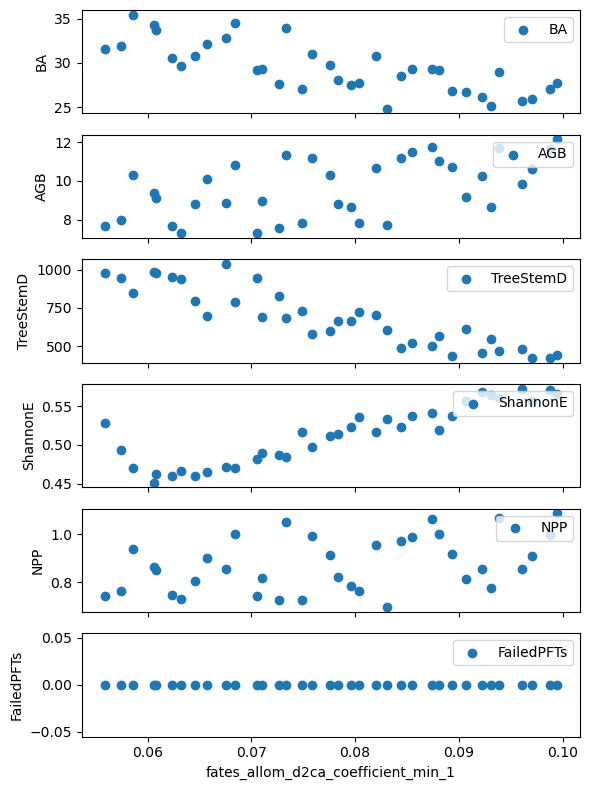

Directory '/glade/scratch/adamhb/processed_output/conifer-allom-083023_-17e2acb6a_FATES-55794e61' created successfully!


<Figure size 640x480 with 0 Axes>

In [26]:
bench_dict_a = get_benchmarks(case_name='conifer-allom-083023_-17e2acb6a_FATES-55794e61',
                              metrics = my_metrics,
                              last_n_years=1,
                              param_sub_dir="conifer_allom_083023",
                              param_range_file_name = 'param_ranges_conifer_allom_test_083023.csv',
                              pft_names = ["pine","cedar","fir"],
                              test=False)
bench_df_a = pd.DataFrame(bench_dict_a)
esm_tools.plot_multi_panel(df = bench_df_a, x_col = "fates_allom_d2ca_coefficient_min_1",
                 y_cols = my_metrics, figsize=(6, 8))
esm_tools.store_output('conifer-allom-083023_-17e2acb6a_FATES-55794e61',bench_df_a,processed_output_root = processed_output_root)

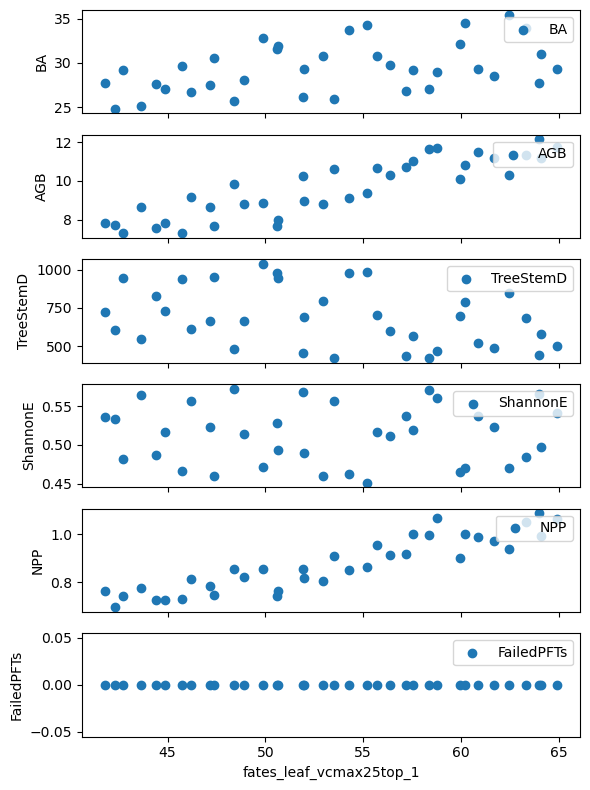

Directory '/glade/scratch/adamhb/processed_output/conifer-allom-083023_-17e2acb6a_FATES-55794e61' already exists!


<Figure size 640x480 with 0 Axes>

In [27]:
esm_tools.plot_multi_panel(df = bench_df_a, x_col = "fates_leaf_vcmax25top_1",
                 y_cols = my_metrics, figsize=(6, 8))
esm_tools.store_output('conifer-allom-083023_-17e2acb6a_FATES-55794e61',bench_df_a,processed_output_root = processed_output_root)